# c.f. It is different from saved_gt  and diced_gt

## Load a diced_gt

In [1]:
import json
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

from diced import DicedStore

store = DicedStore("gs://flyem-public-connectome")
repo_grayscale = store.open_repo("medulla7column")
repo_groundtruth = store.open_repo("medulla7column")


In [2]:
grayscale = repo_grayscale.get_array("grayscale")
groundtruth = repo_groundtruth.get_array("groundtruth")

In [3]:
xmin = 3253
xmax = 3773
ymin = 2103
ymax = 2623
zmin = 3490
zmax = 4010
origin_gt_cube = groundtruth[zmin:zmax, ymin:ymax, xmin:xmax] 

unique_origin_gt_cube = np.unique(origin_gt_cube)
origin_gt_cube.shape

(520, 520, 520)

## Load a saved_get

In [23]:
import h5py
import numpy as np
# conda install -c anaconda h5py
"""
Reference : https://stackoverflow.com/questions/27710245/is-there-an-analysis-speed-or-memory-usage-advantage-to-using-hdf5-for-large-arr
Saving 'thousand_gry' as np.array-from, its size is 2.7GB
but saving 'thousand_gry' as hdf-from, its size is 1.1GB
"""
def hdf_read(path, keyword):
    f = h5py.File(path, 'r')
    return f[keyword]

def hdf_write(path, keyword, data):
    with h5py.File(path, 'w') as outfile:
        dset = dset = outfile.create_dataset(keyword, data=data, chunks=True)

In [ ]:
gt_path = '/data/git/ffn/third_party/neuroproof_examples/validation_sample/groundtruth.h5'
saved_gt = np.array(hdf_read(gt_path, 'stack'))

unique_saved_gt = np.unique(saved_gt)
saved_gt.shape

## check a saved_gt same with a diced_gt

In [ ]:
from scipy import ndimage as ndi
from skimage import color

z_value = 30

color_labels = color.label2rgb(origin_gt_cube[z_value, :, :])
plt.imshow(color_labels, alpha=0.3)
# plt.savefig('raw+gt_%d_by_google.png' % z_value, transparent=True)
plt.show()

In [ ]:
color_labels = color.label2rgb(saved_gt[z_value, :, :], alpha=0.1)

plt.imshow(color_labels, alpha=0.3)
# plt.savefig('raw+inference_%d_by_google.png' % z_value, transparent=True)
plt.show()

In [ ]:
print(len(unique_saved_gt) == len(unique_origin_gt_cube))
print(len(unique_saved_gt))
print(len(unique_origin_gt_cube))

----------------------------------------------------------------------------------------------

# Save and load a diced_gt_from_server

In [5]:
import h5py
import numpy as np
# conda install -c anaconda h5py
"""
Reference : https://stackoverflow.com/questions/27710245/is-there-an-analysis-speed-or-memory-usage-advantage-to-using-hdf5-for-large-arr
Saving 'thousand_gry' as np.array-from, its size is 2.7GB
but saving 'thousand_gry' as hdf-from, its size is 1.1GB
"""
def hdf_read(path, keyword):
    f = h5py.File(path, 'r')
    return f[keyword]

import os
if not os.path.exists("./save/diced_gt_from_server.hdf"):
    with h5py.File("./save/diced_gt_from_server.hdf", "w") as outfile:
        dset = outfile.create_dataset('diced_gt_from_server', data=origin_gt_cube, chunks=True)
    diced_gt = origin_gt_cube
else:
    gt_path = "./save/diced_gt_from_server.hdf"
    diced_gt = np.array(hdf_read(gt_path, 'diced_gt_from_server'))

# Get neuron coordinates

In [6]:
import json
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Open roi.json file and specify as a numpy array:

with open('json_repo/roi.json', 'r') as f:
    data = json.load(f)
    
roi_idx = np.array(data)
roi_idx[0:5]


array([[ 53,  77, 101, 149],
       [ 53,  78, 101, 149],
       [ 53,  79, 101, 149],
       [ 53,  80, 101, 149],
       [ 53,  81, 101, 149]])

In [7]:
# Create DataFrame from 'roi_idx':

col_name = ['z_start', 'y_start', 'x0_start', 'x1_start']
df = pd.DataFrame(roi_idx, columns=col_name)
df.head(5)


,z_start,y_start,x0_start,x1_start
0,53,77,101,149
1,53,78,101,149
2,53,79,101,149
3,53,80,101,149
4,53,81,101,149


In [8]:
# Translate to voxel coorinates:

df_coord = df * 32
df_coord.head(5)


,z_start,y_start,x0_start,x1_start
0,1696,2464,3232,4768
1,1696,2496,3232,4768
2,1696,2528,3232,4768
3,1696,2560,3232,4768
4,1696,2592,3232,4768


In [9]:
# Load the synapse.json file:

with open('json_repo/synapse.json', 'r') as f:
    synapse_json = json.load(f)
    
# Get the location of specific 'T-bar': 

data = synapse_json['data'][22]
loc_tbar = data['T-bar']['location']
print("The voxel coordinates of T-bar is [x, y, z] = " + str(loc_tbar))

# Get the locations of its 'partners':

partners = data['partners']
loc_part = [partners[i]['location'] for i in range(len(partners))]

for i, loc in enumerate(loc_part):
    print("The voxel coordinates of its partner {} is [x, y, z] = ".format(i) + str(loc_part[i]))


The voxel coordinates of T-bar is [x, y, z] = [1888, 3111, 7120]
The voxel coordinates of its partner 0 is [x, y, z] = [1884, 3090, 7118]
The voxel coordinates of its partner 1 is [x, y, z] = [1880, 3114, 7111]


In [10]:
# Get all of the T-bar locations in synapse.json:

data = synapse_json['data']

tbar_loc_list = []

for i in range(len(data)):
    tbar = data[i]['T-bar']
    x, y, z = tbar['location']
    tbar_loc_list.append([i, tbar['body ID'], x, y, z])

# Create the DataFrame of T-bar:

col_name = ['data', 'body ID', 'loc (x)', 'loc (y)', 'loc (z)']

tbar_df = pd.DataFrame(tbar_loc_list, columns=col_name)
tbar_df['category'] = 'T-bar'
print('The DataFrame of tbar_df would have ' + str(len(tbar_df)) + ' of rows')
tbar_df.tail(5)


The DataFrame of tbar_df would have 52871 of rows


,data,body ID,loc (x),loc (y),loc (z),category
52866,52866,39326,5015,3301,1731,T-bar
52867,52867,20789,5015,3653,1876,T-bar
52868,52868,39727,5017,3134,1834,T-bar
52869,52869,28700,5017,3468,2353,T-bar
52870,52870,82080,5017,3695,1906,T-bar


In [11]:
# Get all of the Partners locations corresponding to T-bars in synapse.json:

data = synapse_json['data']

partners_loc_list = []

for i in range(len(data)):
    partners = data[i]['partners']
    for j in range(len(partners)):
        x, y, z = partners[j]['location']
        partners_loc_list.append([i, partners[j]['body ID'], x, y, z])
    
# Create the DataFrame of Partners:

col_name = ['data', 'body ID', 'loc (x)', 'loc (y)', 'loc (z)']

partner_df = pd.DataFrame(partners_loc_list, columns=col_name)
partner_df['category'] = 'partner'

print('The DataFrame of partner_df would have ' + str(len(partner_df)) + ' of rows')
partner_df.tail(5)
    

The DataFrame of partner_df would have 313219 of rows


,data,body ID,loc (x),loc (y),loc (z),category
313214,52869,84374,5007,3457,2368,partner
313215,52870,42310,5010,3684,1906,partner
313216,52870,16699,4999,3695,1906,partner
313217,52870,33690,5003,3704,1896,partner
313218,52870,40513,4998,3701,1916,partner


In [12]:
synapse_df = tbar_df.append(partner_df).reset_index(drop=True)

synapse_df.tail(5)


,data,body ID,loc (x),loc (y),loc (z),category
366085,52869,84374,5007,3457,2368,partner
366086,52870,42310,5010,3684,1906,partner
366087,52870,16699,4999,3695,1906,partner
366088,52870,33690,5003,3704,1896,partner
366089,52870,40513,4998,3701,1916,partner


In [13]:
# Get location of synapse inside of example:
xmin = 3253
xmax = 3773
ymin = 2103
ymax = 2623
zmin = 3490
zmax = 4010

x_cond = (synapse_df['loc (x)'] >= xmin) & (synapse_df['loc (x)'] <= xmax)
y_cond = (synapse_df['loc (y)'] >= ymin) & (synapse_df['loc (y)'] <= ymax)
z_cond = (synapse_df['loc (z)'] >= zmin) & (synapse_df['loc (z)'] <= zmax)

valid_synapse = synapse_df[x_cond & y_cond & z_cond]


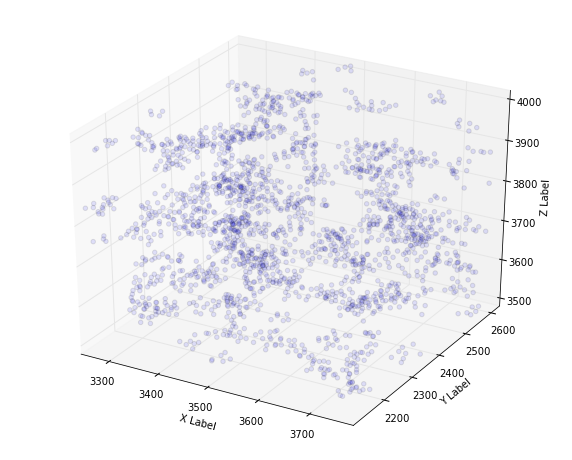

In [14]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
    
ax.scatter(valid_synapse.iloc[:, 2],
           valid_synapse.iloc[:, 3],
           valid_synapse.iloc[:, 4], marker='o', label=valid_synapse.iloc[:,5], alpha=0.1)    
  
ax.set_zlim(zmin, zmax)
ax.set_ylim(ymin, ymax)
ax.set_xlim(xmin, xmax)
    
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Save and load

In [35]:
import pickle

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def save_object(input_object):
    name = namestr(input_object, globals())[0]
    with open('./save/' + name + '.dmp', 'wb') as f:
        pickle.dump(input_object, f)
        
def load_object(input_object):
    name = namestr(input_object, globals())[0]
    with open('./save/' + name + '.dmp', 'rb') as f:
        loaded_f = pickle.load(f)
    return loaded_f

In [34]:
import h5py
import numpy as np
# conda install -c anaconda h5py
"""
Reference : https://stackoverflow.com/questions/27710245/is-there-an-analysis-speed-or-memory-usage-advantage-to-using-hdf5-for-large-arr
Saving 'thousand_gry' as np.array-from, its size is 2.7GB
but saving 'thousand_gry' as hdf-from, its size is 1.1GB
"""
def hdf_read(path, keyword):
    f = h5py.File(path, 'r')
    return f[keyword]

def hdf_write(path, keyword, data):
    with h5py.File(path, 'w') as outfile:
        dset = dset = outfile.create_dataset(keyword, data=data, chunks=True)

# get a neuron_gt

In [7]:
import os
if not os.path.exists("./save/neuron_gt.dmp"):
    ##!! First, you have to laod a origin_gt_cube from diced server
    # Get neuron_coordinates
    neuron_coord_z = valid_synapse['loc (z)'].values
    neuron_coord_y = valid_synapse['loc (y)'].values
    neuron_coord_x = valid_synapse['loc (x)'].values

    assert len(neuron_coord_z) == len(neuron_coord_y) == len(neuron_coord_x)
    
    # Get a neuron_gt list
    neuron_gt = []
    for z,y,x in zip(neuron_coord_z, neuron_coord_y, neuron_coord_x):
        val = (int)(origin_gt_cube[z:z+1,y:y+1,x:x+1].flatten().tolist()[0])
        if not val in neuron_gt:
            neuron_gt.append(val)
    save_object(neuron_gt)
    print("saving neuron_gt complete")
else:
    neuron_gt=[] # Define a dummy variable to get a variable's name
    neuron_gt = load_object(neuron_gt)
    print("loading neuron_gt complete")

loading neuron_gt complete


In [8]:
neuron_gt

[38210,
 163355,
 48661,
 10693,
 498812,
 7021,
 192082,
 7131,
 172939,
 7463,
 158346,
 172374,
 212546,
 212511,
 160142,
 200348,
 7892,
 151837,
 199521,
 28668,
 8502,
 149686,
 700,
 225006,
 160441,
 17092,
 16677,
 48665,
 16497,
 199572,
 212958,
 211501,
 161075,
 284014,
 211627,
 160336,
 212897,
 19223,
 161124,
 31749,
 166862,
 160708,
 211867,
 161173,
 212997,
 26486,
 212129,
 16660,
 16681,
 211628,
 26471,
 26353,
 273324,
 26747,
 27910,
 96147,
 18274,
 211482,
 159919,
 21969,
 1896,
 211513,
 269760,
 148895,
 199729,
 199877,
 200133,
 200137,
 200199,
 8749,
 201401,
 213408,
 149154,
 58969,
 384007,
 200461,
 16699,
 2374,
 202336,
 7086,
 149522,
 211722,
 200796,
 138938,
 201081,
 200380,
 147831,
 148949,
 212120,
 212389,
 9423,
 213364,
 3226854,
 212803,
 201071,
 200020,
 201430,
 199491,
 201465,
 201525,
 212329,
 18326,
 302,
 213200,
 201543,
 213205,
 199486,
 211822,
 148875,
 212150,
 213134,
 201489,
 216366,
 212989,
 212623,
 200308,
 201

In [9]:
1896 in neuron_gt 

True

In [10]:
# check all "body ID" made by neuron_gt
neuron_ids = valid_synapse['body ID'].values

for i in neuron_ids.tolist():
    if not i in neuron_gt:
        print("%d 없음" % i)

NameError: name 'valid_synapse' is not defined

# Get neuron get cube and non_neuron_gt_cube

In [11]:
indice_bool = np.isin(diced_gt,neuron_ids)
indice = np.where(indice_bool)

NameError: name 'diced_gt' is not defined

In [12]:
indice

NameError: name 'indice' is not defined

In [13]:
diced_gt[0,7,469] in neuron_gt

NameError: name 'diced_gt' is not defined

In [14]:
# neuron_gt_cube = np.zeros((diced_gt.shape), dtype=np.int)
# non_neuron_gt_cube = diced_gt.copy()

# for z,y,x in zip(indice[0], indice[1], indice[2]):
#     neuron_gt_cube[z,y,x] = diced_gt[z,y,x]
#     non_neuron_gt_cube[z,y,x] = 0
#     if not diced_gt[z,y,x] in neuron_gt :
#         print('% d is not in neuron_gt' % diced_gt[z,y,x])

In [15]:
neuron_gt_cube = np.zeros((diced_gt.shape), dtype=np.int)
non_neuron_gt_cube = diced_gt.copy()

neuron_gt_cube[indice] = diced_gt[indice]
non_neuron_gt_cube[indice] = 0

NameError: name 'diced_gt' is not defined

In [16]:
np.unique(neuron_gt_cube)

NameError: name 'neuron_gt_cube' is not defined

# Draw a neuron scatter plot

In [17]:
neuron_gt_cube_path = "./save/neuron_gt_cube.hdf"
non_neuron_gt_cube_path = "./save/non_neuron_gt_cube.hdf"

if not (os.path.exists("./save/neuron_gt_cube.hdf") and os.path.exists("./save/non_neuron_gt_cube.hdf")):
    hdf_write(neuron_gt_cube_path, "neuron_gt_cube", neuron_gt_cube)
    hdf_write(non_neuron_gt_cube_path, "non_neuron_gt_cube", non_neuron_gt_cube)
else:
    neuron_gt_cube = np.array(hdf_read(neuron_gt_cube_path, "neuron_gt_cube"))
    non_neuron_gt_cube = np.array(hdf_read(non_neuron_gt_cube_path, "non_neuron_gt_cube"))


In [18]:
"""
##!#!#!# Caution #!#!#!##
If you run this code, you will be wait long time
as you want to run this, unannotate last line
'neuron_gt_cube.vtk' is 10.0GB
"""
from tvtk.api import tvtk, write_data
# conda install -c anaconda mayavi 
def array2vtk(data, name):
    grid = tvtk.ImageData(spacing=(1,1,1), origin=(0, 0, 0), dimensions=data.shape)
    grid.point_data.scalars = data.ravel()
    grid.point_data.scalars.name = name

#     write_data(grid, './save/'+ name + '.vtk')

In [19]:
array2vtk(neuron_gt_cube, "neuron_gt_cube")
array2vtk(non_neuron_gt_cube, "non_neuron_gt_cube")

-------------------------------------------------------------------------------------------------------------------------

In [20]:
indice_bool = np.isin(neuron_gt_cube,1896)
indice = np.where(indice_bool)

mask = np.zeros((neuron_gt_cube.shape), dtype=np.int)
mask[indice] = 1
np.unique(mask)

array([0, 1])

In [24]:
from mayavi import mlab
import numpy as np
mlab.contour3d(mask)
mlab.show()
# neuron_gt_cube.shape

In [16]:
a = (neuron_gt_cube == 1896).astype(np.int)

In [41]:
np.unique(a.flatten()).tolist().count(1)

1

In [26]:
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, skeletonize_3d
from skimage.data import binary_blobs

skeleton3d = skeletonize_3d(mask)
mlab.contour3d(skeleton3d)
mlab.show()
mlab.contour3d(mask)
mlab.show()

--------------------------------------------------------------------------------------------------------

# Make a data bundle (150 x 150 x 150 * 21)

In [57]:
import json
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

from diced import DicedStore

store = DicedStore("gs://flyem-public-connectome")
repo_grayscale = store.open_repo("medulla7column")
repo_groundtruth = store.open_repo("medulla7column")


In [58]:
grayscale = repo_grayscale.get_array("grayscale")
groundtruth = repo_groundtruth.get_array("groundtruth")

In [59]:
import json
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Open roi.json file and specify as a numpy array:

with open('json_repo/roi.json', 'r') as f:
    data = json.load(f)
    
roi_idx = np.array(data)

# len(roi_idx)
roi_idx[0:5]


array([[ 53,  77, 101, 149],
       [ 53,  78, 101, 149],
       [ 53,  79, 101, 149],
       [ 53,  80, 101, 149],
       [ 53,  81, 101, 149]])

In [60]:
old_xmin = 3253
old_xmax = 3773
old_ymin = 2103
old_ymax = 2623
old_zmin = 3490
old_zmax = 4010

def check_coord_in_old(z_coord, y_coord, x_coord, idx):
    if z_coord >= old_zmin and z_coord <= old_zmax \
        and y_coord >= old_ymin and y_coord <=old_ymax \
        and x_start+idx*150 >= old_xmin and x_start+idx*150 + 150 <=old_xmax :
        return True
    else:
        return False

In [61]:
import math
roi_coord = roi_idx * 32

container = []
z_temp = 0
y_temp = 0

for idx in range(len(roi_coord)):
    z_coord = roi_coord[idx][0]
    y_coord = roi_coord[idx][1]
    if (math.fabs(y_temp - y_coord) >= 150 and math.fabs(z_temp - z_coord) >= 150):
        x_start = roi_coord[idx][2]
        x_end   = roi_coord[idx][3]
        for idx in range((x_end - x_start)/ 150):
            if not check_coord_in_old(z_coord, y_coord, x_start, idx):
                element = [z_coord, y_coord, x_start+idx*150]
                container.append(element)
        y_temp = y_coord
        z_temp = z_coord

In [62]:
container

[[1696, 2464, 3232],
 [1696, 2464, 3382],
 [1696, 2464, 3532],
 [1696, 2464, 3682],
 [1696, 2464, 3832],
 [1696, 2464, 3982],
 [1696, 2464, 4132],
 [1696, 2464, 4282],
 [1696, 2464, 4432],
 [1696, 2464, 4582],
 [1856, 2624, 3232],
 [1856, 2624, 3382],
 [1856, 2624, 3532],
 [1856, 2624, 3682],
 [1856, 2624, 3832],
 [1856, 2624, 3982],
 [1856, 2624, 4132],
 [1856, 2624, 4282],
 [1856, 2624, 4432],
 [1856, 2624, 4582],
 [2016, 2464, 3232],
 [2016, 2464, 3382],
 [2016, 2464, 3532],
 [2016, 2464, 3682],
 [2016, 2464, 3832],
 [2016, 2464, 3982],
 [2016, 2464, 4132],
 [2016, 2464, 4282],
 [2016, 2464, 4432],
 [2016, 2464, 4582],
 [2176, 2624, 3232],
 [2176, 2624, 3382],
 [2176, 2624, 3532],
 [2176, 2624, 3682],
 [2176, 2624, 3832],
 [2176, 2624, 3982],
 [2176, 2624, 4132],
 [2176, 2624, 4282],
 [2176, 2624, 4432],
 [2176, 2624, 4582],
 [2336, 2464, 3232],
 [2336, 2464, 3382],
 [2336, 2464, 3532],
 [2336, 2464, 3682],
 [2336, 2464, 3832],
 [2336, 2464, 3982],
 [2336, 2464, 4132],
 [2336, 2464,

In [74]:
# Random sampling indice of container uniformly 
np.random.seed(21)

indice = range(len(container))
random_indice = np.random.choice(indice, 8, replace=False)

In [75]:
random_indice

array([234, 232, 173, 157, 299, 198, 266, 333])

In [90]:
train_data_path = "/data/git/fira-capstone-project/save/train_data"
gry_container = []
gt_container = []


for val in random_indice:
    # Save didn't concatenate data
    path = train_data_path + '/' + 'not_concate_' + str(val)
    
    z, y, x = container[val]
    data_gry = grayscale[z:z+150, y:y+150, x:x+150]
    data_gt = groundtruth[z:z+150, y:y+150, x:x+150]
    if 0 in data_gt:
        print("%d contain 0, gry", val)
    
    hdf_write(path+"_gry", "gry", data_gry)
    hdf_write(path+"_gt", "gt", data_gt)
    
    
    # Save concatenate data
    gry_container.append(data_gry)
    gt_container.append(data_gt)
    
path = train_data_path + '/' + "concate"
stacked_data_gry = np.concatenate(gry_container, axis=0)
stacked_data_gt = np.concatenate(gt_container, axis=0)

hdf_write(path+"_gry", "gry", stacked_data_gry)
hdf_write(path+"_gt", "gt", stacked_data_gt)
print("stacked_data_gry.shape", stacked_data_gry.shape)
print("stacked_data_gt.shape", stacked_data_gt.shape)
    
    
    
# def hdf_write(path, keyword, data):
#     with h5py.File(path, 'w') as outfile:
#         dset = dset = outfile.create_dataset(keyword, data=data, chunks=True)

('stacked_data_gry.shape', (1200, 150, 150))
('stacked_data_gt.shape', (1200, 150, 150))


In [91]:
concat_gry = hdf_read(train_data_path+"/concate_gry", "gry")
print("")
print(concat_gry.shape)
print(concat_gry[0])

concat_gt = hdf_read(train_data_path+"/concate_gt", "gt")
print(concat_gt[0])

concat_gry = hdf_read(train_data_path+"/not_concate_157_gry", "gry")
print("")
print(concat_gry.shape)
print(concat_gry[0])

concat_gt = hdf_read(train_data_path+"/not_concate_157_gt", "gt")
print(concat_gt[0])


# def hdf_read(path, keyword):
#     f = h5py.File(path, 'r')
#     return f[keyword]


(1200, 150, 150)
[[152 144 143 ...,  66  81  76]
 [158 150 147 ...,  80  81  95]
 [166 160 153 ...,  83  87  91]
 ..., 
 [180 170 156 ..., 178 187 184]
 [170 156 150 ..., 169 177 181]
 [175 155 144 ..., 167 172 182]]
[[376495 376495 376495 ...,  82089  82089  82089]
 [376495 376495 376495 ...,  82089  82089  82089]
 [376495 376495 376495 ...,  82089  82089  82089]
 ..., 
 [384054 384054 384054 ..., 457537 457537 457537]
 [384054 384054 384054 ..., 457537 457537 457537]
 [384054 384054 384054 ..., 457537 457537 457537]]

(150, 150, 150)
[[166 164 164 ..., 106 102  88]
 [169 159 155 ..., 104 112  98]
 [173 159 156 ...,  90  97  93]
 ..., 
 [121 119 126 ...,  89  74  75]
 [118 127 133 ...,  81  79  75]
 [126 138 145 ...,  85  83  87]]
[[170754 170754 170754 ..., 226040 226040 226040]
 [170754 170754 170754 ..., 226040 226040 226040]
 [170754 170754 170754 ..., 226040 226040 226040]
 ..., 
 [199493 199493 199493 ...,  16647  16647  16647]
 [199493 199493 199493 ...,  16647  16647  16647]


In [77]:
a = 101*32;
b = 149*32
print(a,b)
(b-a)/150 

3232 + 150*10

(3232, 4768)


4732

In [78]:
a = np.random.random((3,3,3))
b = np.random.random((3,3,3))
c = np.random.random((3,3,3))
a

array([[[ 0.42123128,  0.21229574,  0.77958652],
        [ 0.02455713,  0.51519744,  0.54463426],
        [ 0.90628012,  0.98263181,  0.04015903]],

       [[ 0.23392525,  0.08090107,  0.67977724],
        [ 0.48107998,  0.51143972,  0.54447182],
        [ 0.59080192,  0.90105725,  0.7036275 ]],

       [[ 0.41469298,  0.20652713,  0.44748033],
        [ 0.08322816,  0.57960485,  0.60508785],
        [ 0.99984484,  0.53138267,  0.14255688]]])

In [79]:
np.concatenate((a,b,c), axis=0)

array([[[ 0.42123128,  0.21229574,  0.77958652],
        [ 0.02455713,  0.51519744,  0.54463426],
        [ 0.90628012,  0.98263181,  0.04015903]],

       [[ 0.23392525,  0.08090107,  0.67977724],
        [ 0.48107998,  0.51143972,  0.54447182],
        [ 0.59080192,  0.90105725,  0.7036275 ]],

       [[ 0.41469298,  0.20652713,  0.44748033],
        [ 0.08322816,  0.57960485,  0.60508785],
        [ 0.99984484,  0.53138267,  0.14255688]],

       [[ 0.58364309,  0.33118808,  0.41253686],
        [ 0.73780985,  0.05107151,  0.5711893 ],
        [ 0.91934093,  0.59416357,  0.34722535]],

       [[ 0.67615762,  0.5027751 ,  0.15317089],
        [ 0.31068457,  0.58597339,  0.97656934],
        [ 0.76189765,  0.72431148,  0.36783041]],

       [[ 0.96235767,  0.15840519,  0.40078833],
        [ 0.19212347,  0.97462979,  0.80901784],
        [ 0.126032  ,  0.87105251,  0.43195392]],

       [[ 0.0568426 ,  0.63352532,  0.80391961],
        [ 0.59581046,  0.21778077,  0.33270714],
        